In [1]:
%matplotlib inline
import sys
sys.path.append("../../")
import numpy as np
from simulator import AnalogCore
from simulator import CrossSimParameters
from applications.mvm_params import set_params
import scipy.linalg
import matplotlib
import matplotlib.pyplot as plt
import pickle
from PIL import Image
np.random.seed(198)

# Convert to decibels relative to full scale (dBFS)
def dbfs_rgb(x):
    maxVal = np.max(x)
    db_R = 20*np.log10((x[:,:,0] + np.finfo(float).eps)/maxVal)
    db_G = 20*np.log10((x[:,:,1] + np.finfo(float).eps)/maxVal)
    db_B = 20*np.log10((x[:,:,2] + np.finfo(float).eps)/maxVal)
    return [db_R, db_G, db_B]

# Adding models to CrossSim

In this notebook, we will show some examples of how we can add new models to CrossSim using the Device and ADC interfaces. We will use these two models  with the Fourier transform code you've already been introduced to and show both new devices and new ADC models.


# Part 1: New Device Models

## 1.1: Problem setup

Just as in the previous notebook, we'll start by loading our image which we'll be using for these examples.

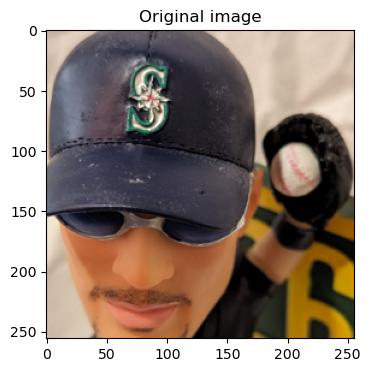

In [2]:
# Load image
N, N, Nch = 256, 256, 3
ichiro = Image.open('../../applications/dsp/example_images/ichiro.jpg').resize((N,N))
ichiro = np.array(ichiro).astype(np.float32) / 255

# Show image
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.imshow(ichiro)
ax.set_title("Original image")
plt.show()

# Set the DFT and inverse DFT matrices for later
W_dft = scipy.linalg.dft(N)
W_idft = np.matrix.getH(W_dft)

# 1.2 A New "perfect_device" Model

Before we add a more complex models we will demonstrate the interface using a new error free device model. CrossSim already contains an `IdealDevice` model which is identical to this model, but this helps show the interface.

In [3]:
from simulator.devices import idevice

class perfect_device(idevice.EmptyDevice):
    
    #### Programming error model
    # Random error is applied to the normalized conductance matrix Gnorm,
    # when the core is initialized
    def programming_error(self, Gnorm):
        return Gnorm
    
    #### Read noise model
    # Random error is applied to the normalized conductance matrix Gnorm,
    # every time an MVM or VMM is called
    def read_noise(self, Gnorm):
        return Gnorm

    #### Drift model
    # Error is applied to the normalized conductance matrix Gnorm that 
    # depends on a time parameter
    def drift_error(self, Gnorm, time):
        return Gnorm

`idevice` short for interface device specifies the interface that all device models in CrossSim must implement. `idevice.EmptyDevice` is a holding class for that allows an implementing device to be incomplete in the sense that it only declares some of the three possible error models.

CrossSim provides three types of device error models, programming noise, sampled when a new matrix is programmed in the array (typically during system start up), read noise which varies each time MVM is called, and drift noise which takes an additional time argument and models the way the progrmamed state changes over time.

Now that we have this new device we can set our parameters as you saw before.

In [4]:
# Set parameters
params = CrossSimParameters()
params.core.complex_matrix = True
params.core.complex_inputs = True
params.xbar.device.Rmin = 50e3 # 50 kiloOhm
params.xbar.device.Rmax = 50e6 # 50 MegaOhm
params.xbar.device.programming_error.enable = True
params.xbar.device.read_noise.enable = True
params.xbar.device.drift_error.enable = True
params.xbar.device.time = 0 # units: days
params.xbar.device.read_noise.model = "perfect_device"
params.xbar.device.programming_error.model = "perfect_device"
params.xbar.device.drift_error.model = "perfect_device"

# Create AnalogCores and program matrix
xbar_dft = AnalogCore(W_dft, params=params)
xbar_idft = AnalogCore(W_idft, params=params)

Now lets simulate 2D image reconstruction with our perfect devices.

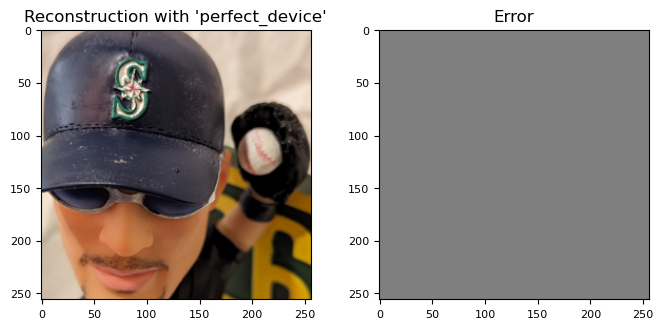

In [5]:
spectrum_xbar = np.zeros(ichiro.shape, dtype=np.complex128)
reconstruction_xbar = np.zeros(ichiro.shape, dtype=np.complex128)

for ch in range(Nch):

    # Compute 2D DFT
    partial_dft = xbar_dft @ ichiro[:,:,ch]
    spectrum_xbar[:,:,ch] = partial_dft @ xbar_dft

    # Compute 2D inverse DFT
    partial_idft = xbar_idft @ spectrum_xbar[:,:,ch]
    reconstruction_xbar[:,:,ch] = partial_idft @ xbar_idft

# Plot the reconstructed image
reconstruction_xbar = np.abs(reconstruction_xbar)/np.max(np.abs(reconstruction_xbar))
error = reconstruction_xbar - ichiro + 0.5
fig,axes = plt.subplots(1,2,figsize=(8,3.5))
axes[0].imshow(reconstruction_xbar)
axes[0].set_title("Reconstruction with 'perfect_device'")
axes[1].imshow(error)
axes[1].set_title("Error")
[ax.tick_params(labelsize=8) for ax in axes]
plt.show()

## 1.3 A More Interesting Device

Now, let's define a more interesting hypothetical device. We'll call it "fictional_flash".
- __Programming error__ is a random normal whose standard deviation depends on conductance: $$\sigma_W(G) = B\left(1 - \exp\left(-AG\right)\right)$$
where $G$ is in nanoSiemens, $A$ = 0.0002/nS and $B$ = 3000 nS. This describes an error that is zero at zero conductance and saturates to 3000 nS at  high conductance.
<br />
- __Read noise__ is a random normal whose standard deviation increases quadratically with $G$: $$\frac{\sigma_R(G)}{G_\text{max}} = 0.2 \left(\frac{G}{G_\text{max}}\right)^2$$
<br />

- __Drift error__ is a simple exponential decay with time: $$ G(t) = G(0) \exp\left(-t/t_0\right)$$ The characteristic decay time $t_0$ varies randomly from device to device, following a normal distribution with mean of 10 days and a standard deviation of 2 days.

In [6]:
class fictional_flash(idevice.EmptyDevice):
    
    #### Programming error model
    def programming_error(self, Gnorm):
        # Convert the normalized conductance matrix into nanoSiemens
        Gmax = 1/self.device_params.Rmin
        G = Gnorm * Gmax * 1e9
        
        # Compute the sigma of the noise to be applied to each element, then
        # apply the random errors to G
        sigma_W = 3000*(1 - np.exp(-0.0002*G))
        G += np.random.normal(loc=0.0, scale=sigma_W, size=G.shape)
        
        # Scale the conductance back down to normalized conductance units
        Gnorm = G * 1e-9 / Gmax
        return Gnorm
    
    #### Read noise model
    # Random error is applied to the normalized conductance matrix Gnorm,
    # every time an MVM or VMM is called
    def read_noise(self, Gnorm):
        sigma_R = 0.2*Gnorm**2
        Gnorm += np.random.normal(loc=0.0, scale=sigma_R, size=Gnorm.shape)
        return Gnorm

    #### Drift model
    # Error is applied to the normalized conductance matrix Gnorm that 
    # depends on a time parameter
    def drift_error(self, Gnorm, time):
        Gprog = self.programming_error(Gnorm)
        t0 = np.random.normal(loc = 10, scale = 2, size=Gprog.shape)
        t0 = np.maximum(t0, 1)
        return Gprog * np.exp(-time/t0)

First, let's look at the effect of programming error alone:

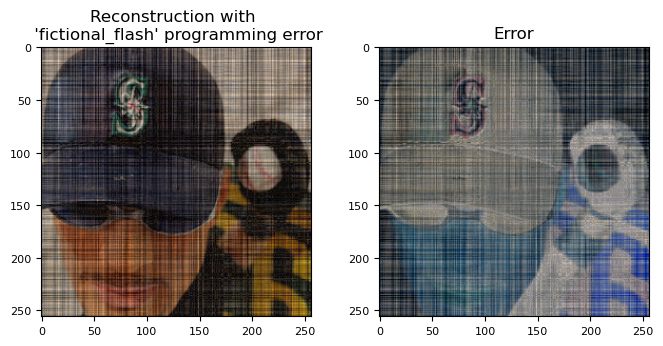

In [7]:
params = CrossSimParameters()

# Core level parameters
params.core.style = "BALANCED"
params.core.complex_matrix = True
params.core.complex_inputs = True
params.core.mapping.inputs.mvm.min = 0
params.core.mapping.inputs.mvm.max = 1

# Device level parameters
params.xbar.device.cell_bits = 7 # target G resolution
params.xbar.device.Rmin = 50e3 # 50 kiloOhm
params.xbar.device.Rmax = 50e6 # 50 MegaOhm
params.xbar.device.read_noise.model = "fictional_flash"
params.xbar.device.programming_error.model = "fictional_flash"
params.xbar.device.drift_error.model = "fictional_flash"
params.xbar.device.time = 0
params.xbar.device.programming_error.enable = True
params.xbar.device.read_noise.enable = False
params.xbar.device.drift_error.enable = False
# clip_conductance = False allows perturbed resistance to fall outside Rmin, Rmax bounds
params.xbar.device.clip_conductance = False

# Create AnalogCores and program matrix
xbar_dft = AnalogCore(W_dft, params=params)
xbar_idft = AnalogCore(W_idft, params=params)

spectrum_xbar = np.zeros(ichiro.shape, dtype=np.complex128)
reconstruction_xbar = np.zeros(ichiro.shape, dtype=np.complex128)

for ch in range(Nch):

    # Compute 2D DFT
    partial_dft = xbar_dft @ ichiro[:,:,ch]
    spectrum_xbar[:,:,ch] = partial_dft @ xbar_dft

    # Compute 2D inverse DFT
    partial_idft = xbar_idft @ spectrum_xbar[:,:,ch]
    reconstruction_xbar[:,:,ch] = partial_idft @ xbar_idft

# Plot the reconstructed image
reconstruction_xbar = np.abs(reconstruction_xbar)/np.max(np.abs(reconstruction_xbar))
error = np.clip(reconstruction_xbar - ichiro + 0.5,0,1)
fig,axes = plt.subplots(1,2,figsize=(8,3.5))
axes[0].imshow(reconstruction_xbar)
axes[0].set_title("Reconstruction with \n 'fictional_flash' programming error")
axes[1].imshow(error)
axes[1].set_title("Error")
[ax.tick_params(labelsize=8) for ax in axes]
plt.show()

Next, let's turn on both programming error and read noise. After programming, we perform the image reconstruction 6 times to see the random effect of read noise. In this example, the read noise effect shows up as somewhat subtle differences in the artifacts that appear in the image from run to run.

Unfortunately, read noise significantly slows down CrossSim, so in the interest of time we're going to use a quarter size version of our test image so we can generate multiple images.

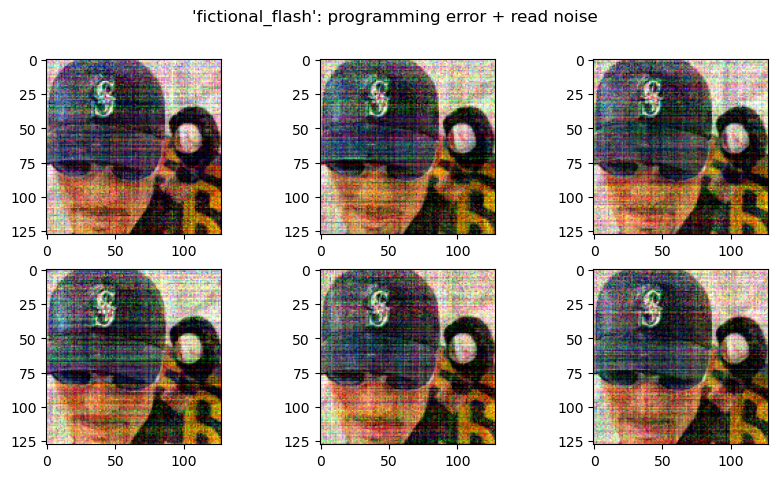

In [8]:
ichiro_small = Image.open('../../applications/dsp/example_images/ichiro.jpg').resize((N//2,N//2))
ichiro_small = np.array(ichiro_small).astype(np.float32) / 255
W_dft_small = scipy.linalg.dft(N//2)
W_idft_small = np.matrix.getH(W_dft_small)

params.xbar.device.time = 0
params.xbar.device.programming_error.enable = False
params.xbar.device.read_noise.enable = True
params.xbar.device.drift_error.enable = False

# Create AnalogCores and program matrix
xbar_dft = AnalogCore(W_dft_small, params=params)
xbar_idft = AnalogCore(W_idft_small, params=params)

Nruns = 6
X_recon = np.zeros((*ichiro_small.shape,Nruns), dtype=np.complex128)
for run in range(Nruns):
    for ch in range(Nch):
        print("Run: {:d}, Channel: {:d}".format(run, ch), end="\r")
        Y_ch = (xbar_dft @ ichiro_small[:,:,ch]) @ xbar_dft
        X_recon[:,:,ch,run] = (xbar_idft @ Y_ch) @ xbar_idft

X_recon = np.real(X_recon / (ichiro_small.shape[0]*ichiro_small.shape[1])).clip(0,1)

# Show reconstructed image
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(10,5))
run = 0
fig.suptitle("'fictional_flash': programming error + read noise")
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.imshow(X_recon[:,:,:,run])
    run += 1
plt.show()


Finally, let's turn on drift errors and look at how the image reconstruction gets worse over time:

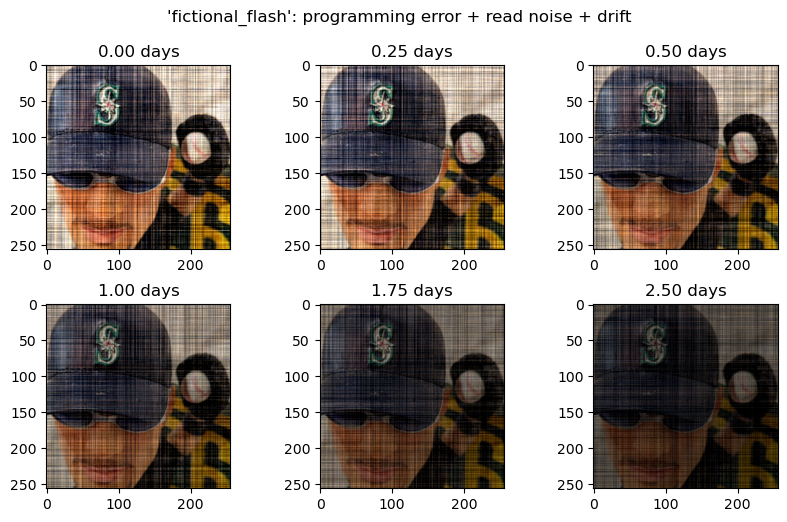

In [9]:
params.xbar.device.programming_error.enable = True
params.xbar.device.read_noise.enable = False
params.xbar.device.drift_error.enable = True

times = np.array([0, 0.25, 0.5, 1, 1.75, 2.5])
X_recon = np.zeros((*ichiro.shape,len(times)), dtype=np.complex128)

for k in range(len(times)):
    params.xbar.device.time = times[k]
    
    # AnalogCores and program matrix
    xbar_dft = AnalogCore(W_dft, params=params)
    xbar_idft = AnalogCore(W_idft, params=params)

    # Perform image reconstruction
    for ch in range(Nch):
        Y_ch = (xbar_dft @ ichiro[:,:,ch]) @ xbar_dft
        X_recon[:,:,ch,k] = (xbar_idft @ Y_ch) @ xbar_idft
        
X_recon = np.real(X_recon / (ichiro.shape[0]*ichiro.shape[1])).clip(0,1)

# Show reconstructed image
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(10,5.5))
plt.subplots_adjust(hspace=0.3)
k = 0
fig.suptitle("'fictional_flash': programming error + read noise + drift")
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.imshow(X_recon[:,:,:,k])
    ax.set_title("{:.2f} days".format(times[k]))
    k += 1
plt.show()

Before moving on from device model, lets look at how we can mix and match different device models within the same device. Say for instance we don't have a model for read noise in our fictional flash. We know it is a flash device so instead lets use the read model from the SONOS device because it is also a flash device. We don't care about drift so we can just set that back to the perfect device we defined above (equivalent to built-in `IdealDevice` or disabling drift all together.

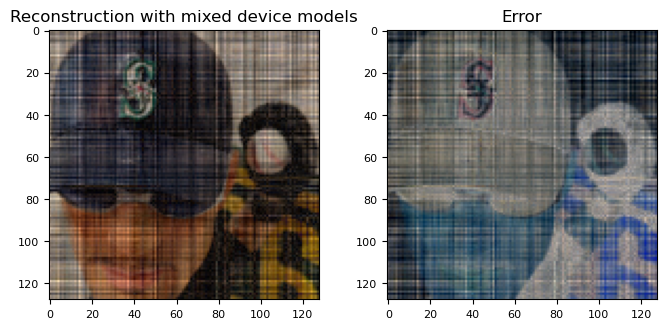

In [10]:
params.xbar.device.time = 0
params.xbar.device.read_noise.enable = True
params.xbar.device.programming_error.model = "fictional_flash"
params.xbar.device.read_noise.model = "SONOS"
params.xbar.device.drift_error.model = "perfect_device"

# Create AnalogCores and program matrix
xbar_dft = AnalogCore(W_dft_small, params=params)
xbar_idft = AnalogCore(W_idft_small, params=params)

spectrum_xbar = np.zeros(ichiro_small.shape, dtype=np.complex128)
reconstruction_xbar = np.zeros(ichiro_small.shape, dtype=np.complex128)

for ch in range(Nch):

    # Compute 2D DFT
    partial_dft = xbar_dft @ ichiro_small[:,:,ch]
    spectrum_xbar[:,:,ch] = partial_dft @ xbar_dft

    # Compute 2D inverse DFT
    partial_idft = xbar_idft @ spectrum_xbar[:,:,ch]
    reconstruction_xbar[:,:,ch] = partial_idft @ xbar_idft

# Plot the reconstructed image
reconstruction_xbar = np.abs(reconstruction_xbar)/np.max(np.abs(reconstruction_xbar))
error = np.clip(reconstruction_xbar - ichiro_small + 0.5,0,1)
fig,axes = plt.subplots(1,2,figsize=(8,3.5))
axes[0].imshow(reconstruction_xbar)
axes[0].set_title("Reconstruction with mixed device models")
axes[1].imshow(error)
axes[1].set_title("Error")
[ax.tick_params(labelsize=8) for ax in axes]
plt.show()

## 1.4 Adding ADC Models
In the previous section when we used an ADC, we used an ideal quantizer, `QuantizerADC`. This ADC model is useful for understanding quantization effects but elides some of the more complex ADC non-idealities like those arising from capacitence mismatch.

Before adding our own new model lets first look at one of the built-in more realistic ADC model, in this case for a Ramp ADC. Ramp ADCs are a potentially interesting candidate for analog PUMs because they use a single shared digital to analog converter (DAC) to generate a reference signal for multiple outputs and only require a much simpler comparator per output.

<img src="./graphics/Ramp_DAC.png" width=300 />

This is the shared DAC that generates the reference signal for all columns, we're going to look at how the output changes when we allow the different capacitors C1 to differ due to fabrication imprecision.

This model is also a little slow because it includes a lot of physically precise details, so in this example we're going to demonstrate another feature of CrossSim's ADC and DAC models, MVM/VMM asymmetry. In this example we're only going to use the RampADC for MVMs and turn it off for VMMs. This may not be physically realistic for many systems but it can also be helpful in isolating application sensitivities.

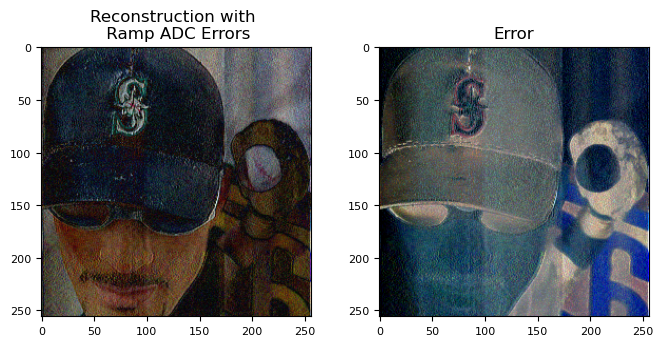

In [11]:
params = CrossSimParameters()

params.core.style = "BALANCED"
params.core.complex_matrix = True
params.core.complex_inputs = True
params.core.mapping.inputs.mvm.min = 0
params.core.mapping.inputs.mvm.max = 1

# Device level parameters
params.xbar.device.cell_bits = 0 # target G resolution
params.xbar.device.Rmin = 50e3 # 50 kiloOhm
params.xbar.device.Rmax = 50e6 # 50 MegaOhm
params.xbar.device.programming_error.enable = False
params.xbar.device.read_noise.enable = False
params.xbar.device.drift_error.enable = False
params.xbar.device.clip_conductance = False

# ADC parameters
params.xbar.adc.match = False

params.xbar.adc.mvm.model = "RampADC"
params.xbar.adc.mvm.signed = True
params.xbar.adc.mvm.bits = 12
params.xbar.adc.mvm.adc_range_option = "CALIBRATED" 
params.xbar.adc.mvm.calibrated_range = (-100, 100)
params.xbar.adc.mvm.model = "RampADC"
params.xbar.adc.mvm.gain_db = 100
params.xbar.adc.mvm.sigma_capacitor = 0.1

params.xbar.adc.vmm.model = "SignMagnitudeADC"
params.xbar.adc.vmm.signed = True
params.xbar.adc.vmm.bits = 12
params.xbar.adc.vmm.adc_range_option = "CALIBRATED" 
params.xbar.adc.vmm.calibrated_range = (-100, 100)

# Create AnalogCores and program matrix
xbar_dft_adc = AnalogCore(W_dft, params=params)
xbar_idft_adc = AnalogCore(W_idft, params=params)

# Numerical ranges for the intermediate results, used to scale the inputs to the analog MVMs
range_partial_dft = 300
range_spectrum = 30000
range_partial_idft = 2

reconstruction_xbar = np.zeros(ichiro.shape, dtype=np.complex128)

for ch in range(Nch):

    # Compute 2D DFT
    partial_dft = xbar_dft_adc @ ichiro[:,:,ch]
    partial_dft /= range_partial_dft
    spectrum_ch = partial_dft @ xbar_dft_adc

    # Compute 2D inverse DFT
    spectrum_ch *= range_partial_dft/range_spectrum
    partial_idft = xbar_idft_adc @ spectrum_ch
    partial_dft *= range_spectrum/range_partial_idft
    reconstruction_xbar[:,:,ch] = partial_idft @ xbar_idft_adc
    partial_dft *= range_partial_idft

# Plot the reconstructed image
reconstruction_xbar = np.abs(reconstruction_xbar)/np.max(np.abs(reconstruction_xbar))
error = np.clip(reconstruction_xbar - ichiro + 0.5,0,1)
fig,axes = plt.subplots(1,2,figsize=(8,3.5))
axes[0].imshow(reconstruction_xbar)
axes[0].set_title("Reconstruction with \n Ramp ADC Errors")
axes[1].imshow(error)
axes[1].set_title("Error")
[ax.tick_params(labelsize=8) for ax in axes]
plt.show()

As we saw in the previous section, ADC effects on the DFT significantly degrade the image, but the effect looks very different than the pure quantizer. The effects look quite different due to the different kinds of error from the ADC, a random and biased error as opposed to a zero-centered quantization noise.

For our own model we're going to do something qualitatively different. Now the ADC has no random variations, but the levels will be systematically nonlinear. Rather than equal spacing between levels, the spacing will increase super-linearly with distance from zero with a power law of $x^{1.5}$.

<img src="./graphics/nonlinear_levels.png" width=600 />

In [12]:
from simulator.circuits.adc import iadc

class SuperlinearADC(iadc.IADC):
    def __init__(
        self,
        adc_params,
        dac_params,
        core_params,
        simulation_params,
        bitslice,
    ):
        super().__init__(
            adc_params,
            dac_params,
            core_params,
            simulation_params,
            bitslice,
        )
        self.levels = 2**self.bits

        # Super-linearity exponent (1 = linear)
        self.exponent = 1.5

    
    # This function will define the nonlinearly spaced levels
    def set_limits(self, matrix):
        super().set_limits(matrix)
        
        # For this ADC model, we will force the limits to be symmetric about zero
        if self.min != -self.max:
            raise ValueError("SuperlinearADC limits must be zero symmetric")
        
        # First create a half-set of linearly spaced levels
        linear_levels = np.linspace(0, self.max, 2**(self.bits-1))

        # Make the levels nonlinear
        self.nonlinear_levels = pow(linear_levels, self.exponent)

        # Renormalize to the original max
        self.nonlinear_levels *= self.max / np.max(self.nonlinear_levels)

        # Create the other half of the limits
        self.nonlinear_levels = np.concatenate((
            -self.nonlinear_levels[::-1][:-1],
            self.nonlinear_levels))

    
    # This function will round the input values to the nearest value in the
    # vector of nonlinearly spaced levels
    def convert(self, vector):
        
        if self.bits is None or self.bits == 0:
            return vector
        input_ = vector.clip(self.min, self.max)

        # Matmul
        if len(input_.shape) == 2:
            indices = np.argmin(np.abs(input_[None,:,:] - self.nonlinear_levels[:,None,None]), axis=0)

        # MVM
        else:
            indices = np.argmin(np.abs(input_ - self.nonlinear_levels[:,None]), axis=0)
        
        output = self.nonlinear_levels[indices]
        return output


Similar to devices for ADCs all models must subclass `IADC`, the ADC interface device and implement at a minimum a `convert` function. `init` and `set_limits` can be customized as well. In a better version of this code, we would probably make `exponent` a parameter of this new ADC and created a new `SuperlinearADCParameters` class to contain it. That is more complicated than we have time for here, but would be the proper way to do things.

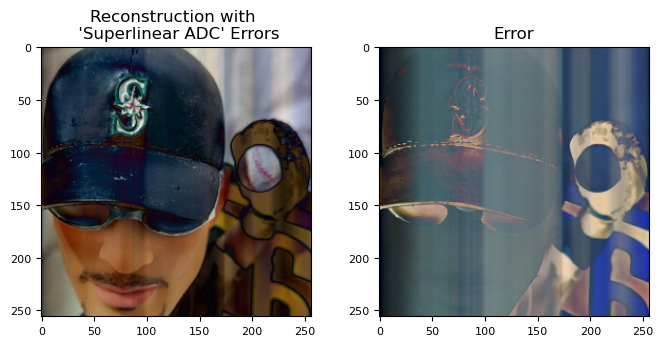

In [13]:
params = CrossSimParameters()

params.core.style = "BALANCED"
params.core.complex_matrix = True
params.core.complex_inputs = True
params.core.mapping.inputs.mvm.min = 0
params.core.mapping.inputs.mvm.max = 1

# Device level parameters
params.xbar.device.cell_bits = 0 # target G resolution
params.xbar.device.Rmin = 50e3 # 50 kiloOhm
params.xbar.device.Rmax = 50e6 # 50 MegaOhm
params.xbar.device.programming_error.enable = False
params.xbar.device.read_noise.enable = False
params.xbar.device.drift_error.enable = False
params.xbar.device.clip_conductance = False

# ADC parameters
params.xbar.adc.match = True
params.xbar.adc.mvm.signed = True
params.xbar.adc.mvm.bits = 12
params.xbar.adc.mvm.adc_range_option = "CALIBRATED" 
params.xbar.adc.mvm.calibrated_range = (-100, 100)
params.xbar.adc.mvm.model = "SuperlinearADC"

# Create AnalogCores and program matrix
xbar_dft_adc = AnalogCore(W_dft, params=params)
xbar_idft_adc = AnalogCore(W_idft, params=params)

# Numerical ranges for the intermediate results, used to scale the inputs to the analog MVMs
range_partial_dft = 300
range_spectrum = 30000
range_partial_idft = 2

reconstruction_xbar = np.zeros(ichiro.shape, dtype=np.complex128)

for ch in range(Nch):

    # Compute 2D DFT
    partial_dft = xbar_dft_adc @ ichiro[:,:,ch]
    partial_dft /= range_partial_dft
    spectrum_ch = partial_dft @ xbar_dft_adc

    # Compute 2D inverse DFT
    spectrum_ch *= range_partial_dft/range_spectrum
    partial_idft = xbar_idft_adc @ spectrum_ch
    partial_dft *= range_spectrum/range_partial_idft
    reconstruction_xbar[:,:,ch] = partial_idft @ xbar_idft_adc
    partial_dft *= range_partial_idft

# Plot the reconstructed image
reconstruction_xbar = np.abs(reconstruction_xbar)/np.max(np.abs(reconstruction_xbar))
error = np.clip(reconstruction_xbar - ichiro + 0.5,0,1)
fig,axes = plt.subplots(1,2,figsize=(8,3.5))
axes[0].imshow(reconstruction_xbar)
axes[0].set_title("Reconstruction with \n 'Superlinear ADC' Errors")
axes[1].imshow(error)
axes[1].set_title("Error")
[ax.tick_params(labelsize=8) for ax in axes]
plt.show()

As before, by creating a non-zero centered set of errors leads to a very different error pattern than the cell noise sources we had before. This shows the importance of handling all your sources of errors differently, rather than attempting to lump them all into a single per-column variable.

Before we finish, lets put both of our new models together just to see how the two different sources of error interact. For speed we're just going to use the programming error model from fictional flash.

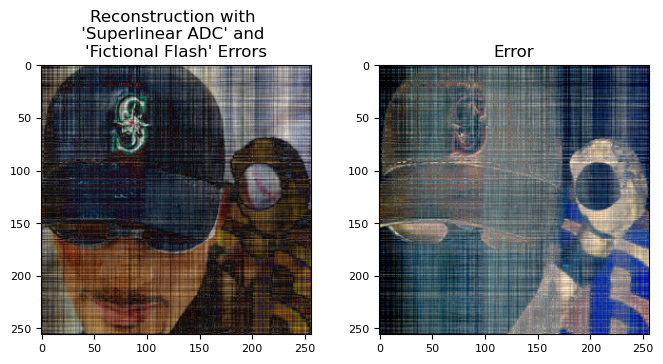

In [14]:
params = CrossSimParameters()

params.core.style = "BALANCED"
params.core.complex_matrix = True
params.core.complex_inputs = True
params.core.mapping.inputs.mvm.min = 0
params.core.mapping.inputs.mvm.max = 1

# Device level parameters
params.xbar.device.cell_bits = 0 # target G resolution
params.xbar.device.Rmin = 50e3 # 50 kiloOhm
params.xbar.device.Rmax = 50e6 # 50 MegaOhm
params.xbar.device.programming_error.model = "fictional_flash"
params.xbar.device.programming_error.enable = True
params.xbar.device.read_noise.enable = False
params.xbar.device.drift_error.enable = False
params.xbar.device.clip_conductance = False

# ADC parameters
params.xbar.adc.match = True
params.xbar.adc.mvm.signed = True
params.xbar.adc.mvm.bits = 12
params.xbar.adc.mvm.adc_range_option = "CALIBRATED" 
params.xbar.adc.mvm.calibrated_range = (-100, 100)
params.xbar.adc.mvm.model = "SuperlinearADC"

# Create AnalogCores and program matrix
xbar_dft_adc = AnalogCore(W_dft, params=params)
xbar_idft_adc = AnalogCore(W_idft, params=params)

# Numerical ranges for the intermediate results, used to scale the inputs to the analog MVMs
range_partial_dft = 300
range_spectrum = 30000
range_partial_idft = 2

reconstruction_xbar = np.zeros(ichiro.shape, dtype=np.complex128)

for ch in range(Nch):

    # Compute 2D DFT
    partial_dft = xbar_dft_adc @ ichiro[:,:,ch]
    partial_dft /= range_partial_dft
    spectrum_ch = partial_dft @ xbar_dft_adc

    # Compute 2D inverse DFT
    spectrum_ch *= range_partial_dft/range_spectrum
    partial_idft = xbar_idft_adc @ spectrum_ch
    partial_dft *= range_spectrum/range_partial_idft
    reconstruction_xbar[:,:,ch] = partial_idft @ xbar_idft_adc
    partial_dft *= range_partial_idft

# Plot the reconstructed image
reconstruction_xbar = np.abs(reconstruction_xbar)/np.max(np.abs(reconstruction_xbar))
error = np.clip(reconstruction_xbar - ichiro + 0.5,0,1)
fig,axes = plt.subplots(1,2,figsize=(8,3.5))
axes[0].imshow(reconstruction_xbar)
axes[0].set_title("Reconstruction with \n 'Superlinear ADC' and  \n'Fictional Flash' Errors")
axes[1].imshow(error)
axes[1].set_title("Error")
[ax.tick_params(labelsize=8) for ax in axes]
plt.show()

## 1.5 What Haven't We Discussed?

- DAC models
- Array models
- Core (data representation) models
- Custom model parameters

All of these are relatively similar to what we've covered with devices and ADCs, subclass an interface and provide the functions required by the interface. New parameters are a bit more involved since the new parameters object must be registered as attached to the model, but conceptually similar.